In [108]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge

In [109]:
df: pd.DataFrame = pd.read_csv(('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'))

In [110]:
features = ["Make", "Model" ,"Year" ,"Engine HP", "Engine Cylinders", "Transmission Type", "Vehicle Style", "highway MPG","city mpg", "MSRP"]
df = df[features].copy()
df.columns = df.columns.str.replace(" ","_").str.lower()
df.rename(columns={"msrp":"price"},inplace=True)


In [111]:
df.columns.tolist()

['make',
 'model',
 'year',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg',
 'price']

In [112]:
df.fillna(0, inplace=True)
df.isnull().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
price                0
dtype: int64

In [113]:
# find above average
price_mean= df.price.mean()
price_mean
df['above_average']= (df.price > price_mean).astype('int64')

# separate numeric from categorical data
categorical = df.dtypes[df.dtypes =='object'].index.tolist()
numeric = df.columns.difference(categorical).tolist()

# create x numeric and y data
data_y = df['above_average'].values
data_x = df[numeric].drop(labels=["price","above_average"],axis=1)

# split data into train, val, test
np.random.seed(1)
x_train, x_test, y_train, test_y =train_test_split(data_x,data_y,test_size=0.2, random_state= 1)
x_train, x_val, y_train, y_val =train_test_split(x_train,y_train,test_size=0.25, random_state= 1)

# 1.

In [114]:
scores = {}
for column in x_train.columns:
    score = roc_auc_score(y_train, x_train[column])
    if score < 0.5:
        score = roc_auc_score(y_train, -x_train[column])
    scores[column] = score
    print(f"{column} : {score}\n")

highest = max(scores.values())

highest_feature = [key for key, value in scores.items() if value == max(scores.values())]
print(f"Therefore, highest auc_score is {highest_feature[0]}")

city_mpg : 0.6734244643245233

engine_cylinders : 0.766116490165669

engine_hp : 0.9171031265539011

highway_mpg : 0.6330587871772013

year : 0.687551492804683

Therefore, highest auc_score is engine_hp


1. answer is engine_hp

# 2.

In [115]:
# create x and y data
from matplotlib import category


data_y = df['above_average'].values
data_x = df[numeric + categorical].drop(labels=["price","above_average"],axis=1)

# split data into train, val, test
np.random.seed(1)
train_x, test_x, train_y, test_y =train_test_split(data_x,data_y,test_size=0.2, random_state= 1)
x_train, x_val, y_train, y_val =train_test_split(train_x,train_y,test_size=0.25, random_state= 1)

x_train_dict =  x_train.to_dict(orient="records")
x_val_dict   =  x_val.to_dict(orient="records")

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(x_train_dict)
X_val = dv.transform(x_val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train,y_train)



LogisticRegression(max_iter=1000, solver='liblinear')

In [116]:
y_pred = model.predict_proba(X_val)[:,1]
score = round(roc_auc_score((y_val),y_pred),3)
score


0.977

2. Answer is 0.979

# 3

In [117]:
np.linspace(0, 1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

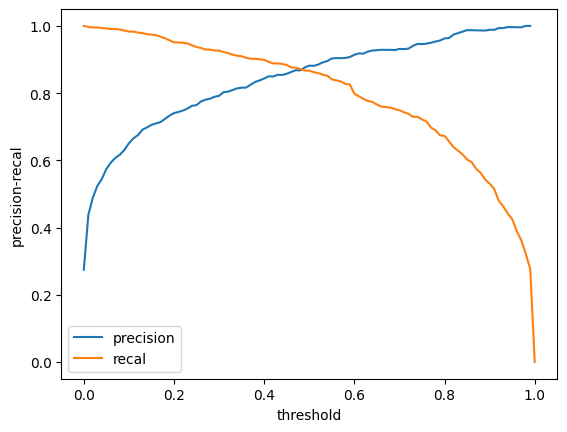

In [118]:
threshold = np.linspace(0, 1, 101)
result = []
for threshold_level in threshold:
    real_positive = (y_val == 1)
    real_negative = (y_val == 0)

    predict_positive = (y_pred >= threshold_level)
    predict_negative = (y_pred < threshold_level)

    tp = (real_positive & predict_positive).sum()
    fp = (real_negative & predict_positive).sum()

    tn = (real_negative & predict_negative).sum()
    fn = (real_positive & predict_negative).sum()
    result.append((threshold_level, tp, tn, fp, fn))

cols = ['threshold', 'tp', 'tn', 'fp', 'fn']
threshold_score_df = pd.DataFrame(result, columns=cols)

threshold_score_df['precision'] = threshold_score_df.tp/(threshold_score_df.tp + threshold_score_df.fp)
threshold_score_df['recal'] = threshold_score_df.tp/(threshold_score_df.tp + threshold_score_df.fn)

plt.plot(threshold_score_df.threshold, threshold_score_df.precision, label= 'precision')
plt.plot(threshold_score_df.threshold, threshold_score_df.recal, label= 'recal')
plt.xlabel("threshold")
plt.ylabel("precision-recal")
plt.legend()


3. answer is 0.48

# 4

,threshold,tp,tn,fp,fn,precision,recall,F1
50,0.5,567,1653,76,87,0.881804,0.866972,0.874325


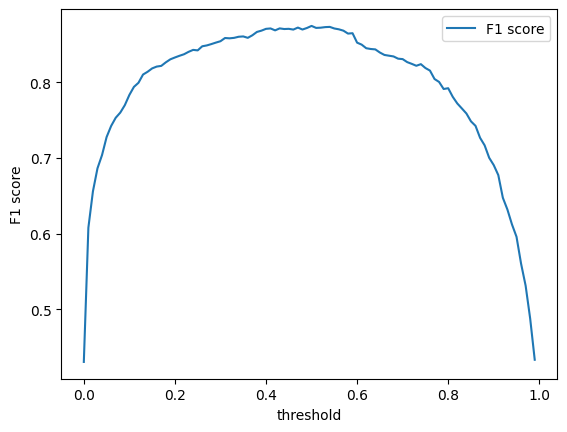

In [119]:
threshold = np.linspace(0, 1, 101)
result = []
for threshold_level in threshold:
    real_positive = (y_val == 1)
    real_negative = (y_val == 0)

    predict_positive = (y_pred >= threshold_level)
    predict_negative = (y_pred < threshold_level)

    tp = (real_positive & predict_positive).sum()
    fp = (real_negative & predict_positive).sum()

    tn = (real_negative & predict_negative).sum()
    fn = (real_positive & predict_negative).sum()
    result.append((threshold_level, tp, tn, fp, fn))

cols = ['threshold', 'tp', 'tn', 'fp', 'fn']
threshold_score_df = pd.DataFrame(result, columns=cols)

threshold_score_df['precision'] = threshold_score_df.tp/(threshold_score_df.tp + threshold_score_df.fp)
threshold_score_df['recall'] = threshold_score_df.tp/(threshold_score_df.tp + threshold_score_df.fn)
threshold_score_df['F1'] = 2 * ((threshold_score_df.precision * threshold_score_df.recall)/(threshold_score_df.precision + threshold_score_df.recall))

plt.plot(threshold_score_df.threshold, threshold_score_df.F1, label= 'F1 score')
plt.xlabel("threshold")
plt.ylabel("F1 score")
plt.legend()
threshold_score_df.nlargest(1, 'F1')


# F1 is maximum at 0.52

# 5

In [120]:
def train(train_x, train_y, C ):
    x_train_dict = train_x.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(x_train_dict)

    model = LogisticRegression(solver='liblinear', C= C, max_iter=1000)
    model.fit(X_train, train_y)

    return dv, model

def predict(test_x, dv, model):
    test_x_dicts = test_x.to_dict(orient='records')

    X = dv.transform(test_x_dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [121]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx , val_idx in kfold.split(x_train, y_train):
    train_x = x_train.iloc[train_idx]
    train_y = y_train[train_idx]

    val_x = x_train.iloc[val_idx]
    val_y = y_train[val_idx]

    dv, model = train(train_x, train_y, C=1.0)
    y_pred = predict(val_x, dv, model)

    auc = roc_auc_score(val_y, y_pred)
    scores.append(auc)
np.std(scores), np.mean(scores)

(0.0012491725533796557, 0.9789578647101941)

In [122]:
np.std(scores), np.mean(scores)

(0.0012491725533796557, 0.9789578647101941)

answer is 0.003

# 6

In [123]:
scores_avg =[]

for C in [0.01, 0.1, 0.5, 10]:

    scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx , val_idx in kfold.split(x_train, y_train):
        train_x = x_train.iloc[train_idx]
        train_y = y_train[train_idx]

        val_x = x_train.iloc[val_idx]
        val_y = y_train[val_idx]

        dv, model = train(train_x, train_y, C=C)
        y_pred = predict(val_x, dv, model)

        auc = roc_auc_score(val_y, y_pred)
        scores.append(auc)
    scores_avg.append((C, np.std(scores), np.mean(scores)))

df= pd.DataFrame(scores_avg, columns=['C','std', 'avg'])
df

,C,std,avg
0,0.01,0.002950,0.948535
1,0.10,0.002568,0.970842
2,0.50,0.002757,0.978299
3,10.00,0.002515,0.978765


In [124]:
df.nlargest(1,'avg')

,C,std,avg
3,10.0,0.002515,0.978765


answer is 10.0